In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class LeNet(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 6, 5)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1 = nn.Linear(16*5*5, 120)
        self.fc2 = nn.Linear(120, 84)
        self.fc3 = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), 2)
        x = F.max_pool2d(F.relu(self.conv2(x)), 2)
        x = torch.flatten(x, 1)
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = F.relu(self.fc3(x))
        return x

In [2]:
def train(model, dev, epoch, batch_size, opt, train_loader, train_accuracy, train_losses, train_counter):
    model.train()
    correct = 0
    for batch_idx, (data, target) in enumerate(train_loader):
        data, target = data.to(dev), target.to(dev)
        opt.zero_grad()
        pred = model(data)
        loss = F.cross_entropy(pred, target)
        loss.backward()
        opt.step()
        pred = pred.argmax(dim=1, keepdim=True)
        correct += pred.eq(target.view_as(pred)).sum().item()
        if batch_idx % 50 == 0:
            accuracy = correct / ((batch_idx+1) * batch_size)
            train_accuracy.append(accuracy)
            train_losses.append(loss.item())
            train_counter.append(batch_idx*batch_size + (epoch - 1)*len(train_loader.dataset))
            print(f"""train epoch: {epoch} [{batch_idx * batch_size}/{len(train_loader.dataset)} ({(100. * batch_idx / len(train_loader)):.0f}%)]\tloss: {loss.item():.10f}\taccuracy: {accuracy:.10f}""")
    
def test(model, dev, batch_size, test_loader, test_accuracy, test_losses):
    model.eval()
    loss, accuracy, correct = 0, 0, 0
    with torch.no_grad():
        for data, target in test_loader:
            data, target = data.to(dev), target.to(dev)
            pred = model(data)
            loss += F.cross_entropy(pred, target).item()
            pred = pred.argmax(dim=1, keepdim=True)
            correct += pred.eq(target.view_as(pred)).sum().item()
    loss /= (len(test_loader.dataset) / batch_size)
    accuracy = correct / len(test_loader.dataset)
    test_accuracy.append(accuracy)
    test_losses.append(loss)
    print(f"\ntest set: average loss: {loss:.4f}, accuracy: {accuracy} ({(100. * accuracy):.0f}%)\n")
    

In [7]:
from torchvision import datasets
from torchvision.transforms import v2
import torch.optim as optim

dev = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f'training on {dev} device')

# hyperparameter
batch_size = 64
epochs = 10
learning_rate = 0.005
momentum = 0.9

model = LeNet().to(dev)
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)

transforms = v2.Compose([v2.Pad(2), v2.ToImage(), v2.ToDtype(torch.float32, scale=True), v2.Normalize(mean=[0.1307], std=[0.3081])])
train_dataset = datasets.MNIST('./data', train=True, transform=transforms)
test_dataset = datasets.MNIST('./data', train=False, transform=transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size)

train_losses = []
train_counter = []
train_accuracy = []
test_losses = []
test_accuracy = []
test_counter = [i*len(train_loader.dataset) for i in range(1, epochs+1)]

for epoch in range(1, epochs+1):
    train(model, dev, epoch, batch_size, optimizer, train_loader, train_accuracy, train_losses, train_counter)
    test(model, dev, batch_size, test_loader, test_accuracy, test_losses)

torch.save(model, 'lenet-model.pt')
torch.save(model.state_dict(), 'lenet-weights.pt')



training on cuda device
train epoch: 1 [0/60000 (0%)]	loss: 2.3091933727	accuracy: 0.0625000000
train epoch: 1 [3200/60000 (5%)]	loss: 2.2823951244	accuracy: 0.1556372549
train epoch: 1 [6400/60000 (11%)]	loss: 2.2237684727	accuracy: 0.2309715347
train epoch: 1 [9600/60000 (16%)]	loss: 1.4157541990	accuracy: 0.2908733444
train epoch: 1 [12800/60000 (21%)]	loss: 1.0219998360	accuracy: 0.3730565920
train epoch: 1 [16000/60000 (27%)]	loss: 0.9990724921	accuracy: 0.4432270916
train epoch: 1 [19200/60000 (32%)]	loss: 0.5950453877	accuracy: 0.5076827243
train epoch: 1 [22400/60000 (37%)]	loss: 0.4954636395	accuracy: 0.5623219373
train epoch: 1 [25600/60000 (43%)]	loss: 0.3069091439	accuracy: 0.6027119701
train epoch: 1 [28800/60000 (48%)]	loss: 0.4850060642	accuracy: 0.6379226718
train epoch: 1 [32000/60000 (53%)]	loss: 0.2552643418	accuracy: 0.6666354790
train epoch: 1 [35200/60000 (59%)]	loss: 0.3780008554	accuracy: 0.6913849819
train epoch: 1 [38400/60000 (64%)]	loss: 0.4020454288	accurac

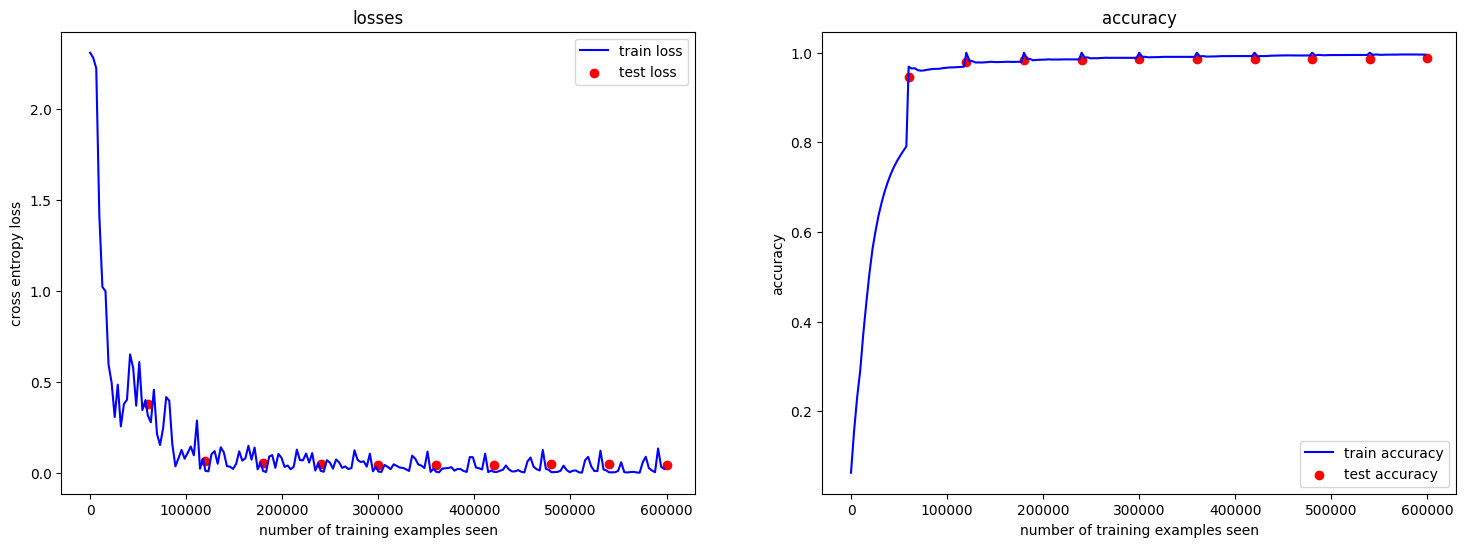

In [9]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(figsize=(18, 6), ncols=2)
# loss
ax1.plot(train_counter, train_losses, color='blue')
ax1.scatter(test_counter, test_losses, color='red')
ax1.legend(['train loss', 'test loss'], loc='upper right')
ax1.set_title('losses')
ax1.set_xlabel('number of training examples seen')
ax1.set_ylabel('cross entropy loss')
# accuracy
ax2.plot(train_counter, train_accuracy, color='blue')
ax2.scatter(test_counter, test_accuracy, color='red')
ax2.legend(['train accuracy', 'test accuracy'], loc='lower right')
ax2.set_title('accuracy')
ax2.set_xlabel('number of training examples seen')
ax2.set_ylabel('accuracy')
plt.show()

In [10]:
# Both are alternatives
lenet_model = torch.load('lenet-model.pt')

lenet_model =LeNet()
lenet_model.load_state_dict(torch.load('lenet-weights.pt'))

/tmp/ipykernel_18455/1814528757.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  lenet_model = torch.load('lenet-model.pt')
/tmp/ipykernel_18455/1814528757.py:5: FutureWa

<All keys matched successfully>

In [13]:
import torch.onnx

model = model.cpu()
x = torch.randn(batch_size, 1, 32, 32)

torch.onnx.export(model, x,'lenet.onnx', export_params=False)
torch.onnx.export(model, x,'lenet-weight.onnx', export_params=True)

torch.onnx.export

In [ ]:
import onnx

lenet_onnx = onnx.load('lenet-weight.onnx')


In [ ]:
import onnx
import onnxruntime as ort
import numpy as np


session = ort.InferenceSession('lenet-weight.onnx')

inputs = {session.get_inputs()[0].name: np.random.randn(64,1,32,32).astype(np.float32)}
outputs = session.run(None, inputs)
outputs
